In [0]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [352]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [0]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def latent_sigmas(self, X):
        return self.sess.run(self.z_log_sigma_sq, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [0]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [356]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 175.368468628
Epoch: 0006 cost= 109.210152768
Epoch: 0011 cost= 104.638360110
Epoch: 0016 cost= 102.472355055
Epoch: 0021 cost= 101.051062858
Epoch: 0026 cost= 100.006190865
Epoch: 0031 cost= 99.189707780
Epoch: 0036 cost= 98.398638819
Epoch: 0041 cost= 97.816685944
Epoch: 0046 cost= 97.225430922
Epoch: 0051 cost= 96.704686127
Epoch: 0056 cost= 96.284708349
Epoch: 0061 cost= 95.875955339
Epoch: 0066 cost= 95.614130152
Epoch: 0071 cost= 95.298529719


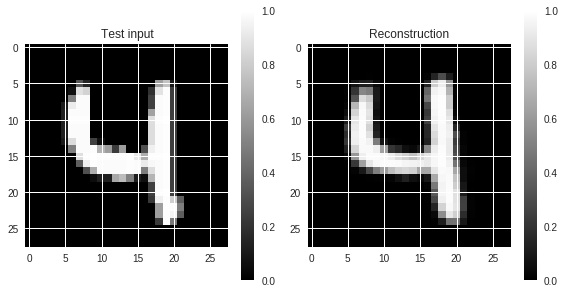

In [357]:
# An example of reconstruction given an input
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 20))
for i in range(1):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [358]:
mnist.train.images.shape

(55000, 784)

In [0]:
im1 = mnist.test.images[0]

In [0]:
lb1 = mnist.test.labels[0]

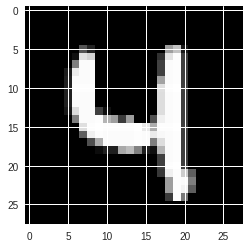

In [361]:
plt.imshow(im1.reshape(28, 28), vmin=0, vmax=1, cmap="gray")

In [0]:
# From one hot representation to decimal
# args: onehot-> list or vector array
# array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])  --> 9
def OneHot2Dec(onehot):
  for idx in range(0, len(onehot)):
    if onehot[idx] == 1:
      return idx

In [363]:
print(lb1)
OneHot2Dec(lb1)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


4

In [0]:
# Collect Samples of a number from a set of images given its labels
# This collection will be sampled randomly, the elected image will be pass through the VAE to generate a new image
def CollectSamplesOfNumber(images, labels, number, nsamples):
  length = images.shape[0]
  ncollected = 0
  im_elected = list()
  lb_elected = list()
  while ncollected < nsamples:
    indx_rndn = np.random.randint(0, length)
    if OneHot2Dec(labels[indx_rndn]) == number:
      ncollected = ncollected + 1
      im_elected.append(images[indx_rndn])
      lb_elected.append(labels[indx_rndn])
      
  return im_elected, lb_elected

In [0]:
# Example Select test images of Ones
I1, L1 = CollectSamplesOfNumber(mnist.test.images, mnist.test.labels, 3, 100)

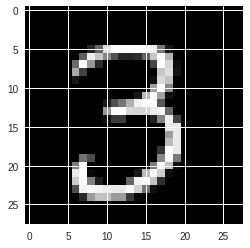

In [367]:
plt.imshow(I1[0].reshape(28, 28), vmin=0, vmax=1, cmap="gray")

In [0]:
# Plot a list of Images of numbers contained in 'Im' in a matrix
def PlotDistribution(Im, nx = 8, ny = 5, size = (5, 8)):
  #nx = 8
  #ny = 5
  canvas = np.empty((28*ny, 28*nx))
  for indy in range(0, ny):
    for indx in range(0, nx):
      canvas[indy*28:(indy+1)*28, indx*28: (indx+1)*28] = Im[indy * 4 + indx].reshape(28,28)
  plt.figure(figsize=size)
  plt.imshow(canvas, origin="upper", cmap="gray")
  plt.grid(False)
  plt.tight_layout()
  return canvas

In [0]:
# Build a table from 0 to 9
def ComputeInputTables(images, labels, nsamples):
  max_number = 9
  images_elected = dict()
  for number in range(0, max_number + 1):
    Ix, _ = CollectSamplesOfNumber(images, labels, number, nsamples)
    images_elected[number] = Ix
    
  return images_elected

In [0]:
# Dictionary of samples the number as key
# A collection of all the images structured in a dictionary, contains (40) images per each number reference as key with its proper number
# im_input_elected[8] give us the collection of 40 images representing the number '8'
# this variable will be used over all the notebook
im_input_elected = ComputeInputTables(mnist.test.images, mnist.test.labels, 1000)

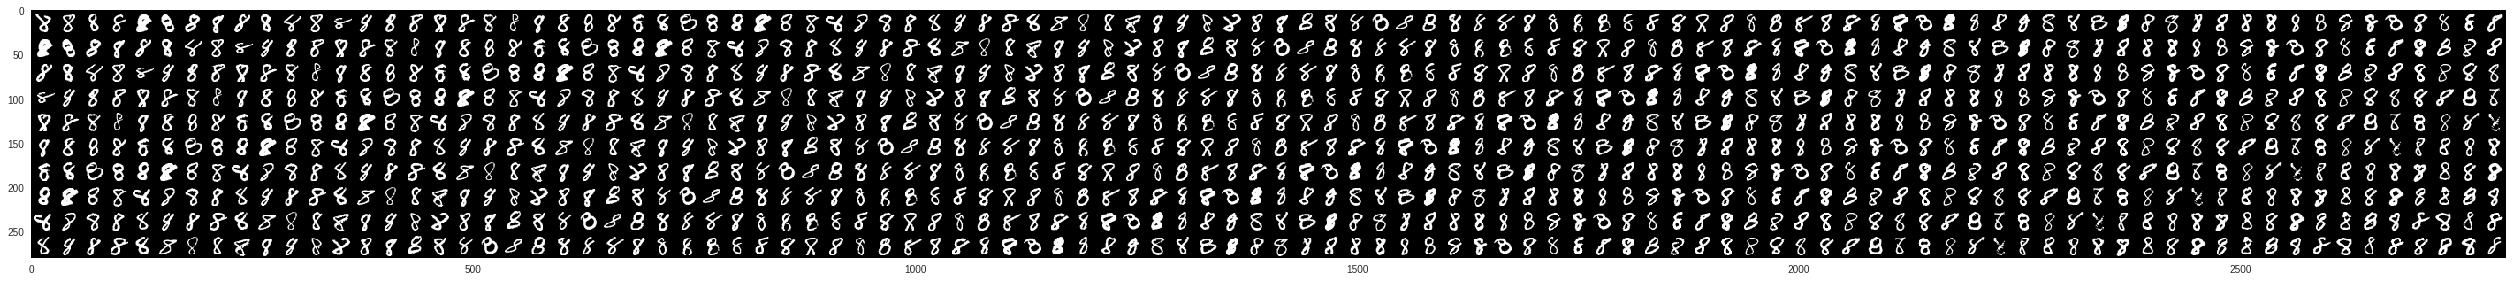

In [450]:
PlotDistribution(im_input_elected[8], nx = 100, ny = 10, size=(35, 15))

In [0]:
# Given a number select randomly an image of input from im_input_elected
def SelectRandomImage(container, number):
  length = len(container[0])
  randindx = np.random.randint(0, length)
  return container[number][randindx]

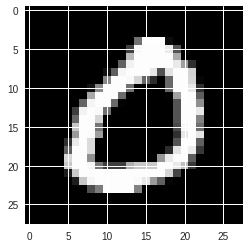

In [452]:
# Example of random elected image
imrndn = SelectRandomImage(im_input_elected, 0)
plt.imshow(imrndn.reshape(28, 28), vmin=0, vmax=1, cmap="gray")

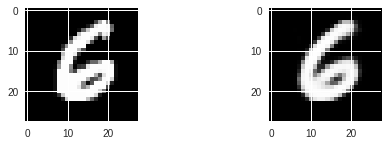

In [376]:
# Generate a reconstructed img
#input_imgs = (SelectRandomImage(im_input_elected, 6), SelectRandomImage(im_input_elected, 9))
input_imgs = np.zeros((100, 784))
input_imgs[0] = SelectRandomImage(im_input_elected, 6)
im_reconstructed = vae.reconstruct(input_imgs)[0]
plt.figure(figsize=(8, 12))
plt.subplot(5, 2, 2*0 + 1)
plt.imshow(input_imgs[0].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
plt.subplot(5, 2, 2*0 + 2)
plt.imshow(im_reconstructed.reshape(28, 28), vmin=0, vmax=1, cmap="gray")

In [0]:
# Overview:
# Generate a sequence of images of the digits from the 'number'
# for example if 'number' = 1564, generate 4 images in that order [ Imagen(1), Imagen(5), Imagen(6), Imagen(4)]
# This function is the started point to generate the captcha
def GenerateSequenceNumbers(number, container, model):
  # Get the digits
  digits = list()
  cocient = number
  while cocient > 0:
    res = cocient%10
    digits.append(res)
    cocient = int(cocient/10)
  digits.reverse()
  # Build the input tensor
  inputs = np.zeros((100, 784))
  for indx in range(0, len(digits)):
    inputs[indx] = SelectRandomImage(container, digits[indx])
  reconstructed = model.reconstruct(inputs)
  imgs_ans = list()
  for indx in range(0, len(digits)):
    imgs_ans.append(reconstructed[indx])
  return imgs_ans

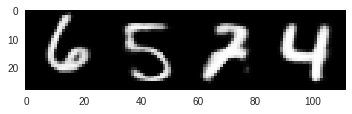

In [453]:
# 'generated' is a list of images generated by the VAE each element is a row of type np.narray of shape(784, )
generated = GenerateSequenceNumbers(6574, im_input_elected, vae)
PlotDistribution(generated, nx = len(generated), ny = 1)

## Processing the numbers, distortion, etc

Random Color

In [0]:
import cv2

In [0]:
# Exploring ...

In [0]:
imex = np.ndarray((28, 28, 3), dtype=float)

In [0]:
imex[:,:,0] = generated[0].reshape(28,28)*0.90

In [0]:
imex[:,:,1] = generated[0].reshape(28,28)*0.20

In [0]:
imex[:,:,2] = generated[0].reshape(28,28)*0.1

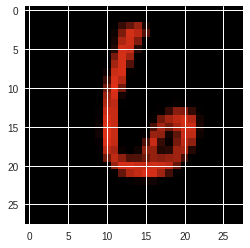

In [385]:
plt.imshow(imex, vmin=0, vmax=1)

In [0]:
# Color a list of grayscale images, with rgb generated randomly
def ColorListImagesRandomly(list_images):
  coloredImages = list()
  for idx in range(0, len(list_images)):
    # Generate the RGB proportions
    col = np.random.rand(3)
    tmpim = np.ndarray((28, 28, 3), dtype=float)
    tmpim[:,:,0] = list_images[idx].reshape(28,28)*col[0]
    tmpim[:,:,1] = list_images[idx].reshape(28,28)*col[1]
    tmpim[:,:,2] = list_images[idx].reshape(28,28)*col[2]
    coloredImages.append(tmpim)
  return coloredImages

In [0]:
# Color a list of grayscale images, with rgb generated randomly
def GrayRGB(list_images):
  coloredImages = list()
  for idx in range(0, len(list_images)):
    # Generate the RGB proportions
    col = np.random.rand(3)
    tmpim = np.ndarray((28, 28, 3), dtype=float)
    tmpim[:,:,0] = list_images[idx].reshape(28,28)*col[0]
    tmpim[:,:,1] = list_images[idx].reshape(28,28)*col[1]
    tmpim[:,:,2] = list_images[idx].reshape(28,28)*col[2]
    coloredImages.append(tmpim)
  return coloredImages

In [0]:
# Plot a list of Images-RGB of numbers contained in 'Im' in a matrix
def PlotDistributionRGB(Im, nx = 8, ny = 5, size = (5, 8)):
  #nx = 8
  #ny = 5
  canvas = np.empty((28*ny, 28*nx, 3))
  for indy in range(0, ny):
    for indx in range(0, nx):
      canvas[indy*28:(indy+1)*28, indx*28: (indx+1)*28,:] = Im[indy * 4 + indx]
  plt.figure(figsize=size)
  plt.imshow(canvas, origin="upper")
  plt.grid(False)
  plt.tight_layout()
  return canvas

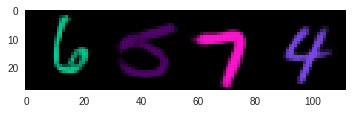

In [388]:
# Color the list 'generated'
ColoredIms = ColorListImagesRandomly(generated)
PlotDistributionRGB(ColoredIms, len(ColoredIms), 1)

# Summary of function at the momment

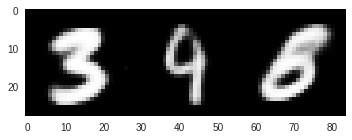

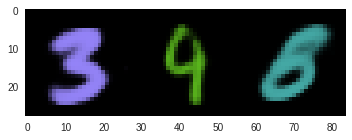

In [389]:
# 'generated' is a list of images generated by the VAE each element is a row of type np.narray of shape(784, )
generated = GenerateSequenceNumbers(348, im_input_elected, vae)
PlotDistribution(generated, nx = len(generated), ny = 1)
# Color the list 'generated'
ColoredIms = ColorListImagesRandomly(generated)
PlotDistributionRGB(ColoredIms, len(ColoredIms), 1)

# Exploring the Latent Space

In [0]:
latentspace_rnd = np.random.normal(size=(100,20))

In [391]:
latentspace_rnd.shape

(100, 20)

**Example** 
Generate 100 numbers randomly from the latent space

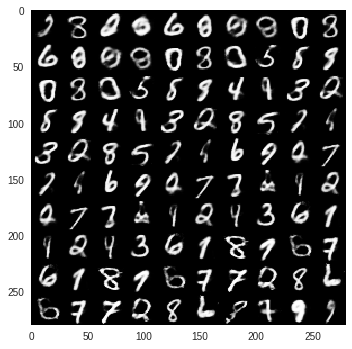

In [392]:
generatedLatentSpace = vae.generate(latentspace_rnd)
PlotDistribution(generatedLatentSpace, nx = 10, ny = 10)

In [393]:
# computing means of each num
vae.transform(im_input_elected[0]).shape

(100, 20)

In [397]:
vae.latent_sigmas(im_input_elected[0])[0]

array([-5.70291901e+00, -1.70188475e+00, -1.15961079e-02, -4.67273712e+00,
       -1.28283985e-02, -4.01332951e+00,  2.52834391e-02, -4.08856297e+00,
       -4.64865112e+00, -1.43616917e-02, -2.37693262e+00, -4.46341085e+00,
       -5.97302008e+00,  1.18544549e-02, -4.22592163e-02, -3.41901851e+00,
       -1.07949423e-02,  9.51534882e-03, -5.86790033e-03, -3.86760235e+00],
      dtype=float32)

**Compute the means and standard desviation for each digits from a collection of images correctly labeled**

This is in variable *im_input_elected* that was declared before

In [0]:
def ComputeLatentSpaceDigits(model, container):
  # N latentsplace
  nlatentspace = 20
  means = dict()
  sigmas = dict()
  for digit in range(0, 10):
    mxx = model.transform(container[digit])
    stdxx = model.latent_sigmas(container[digit])
    mu = mxx.sum(axis = 0)/mxx.shape[0]
    #mstd = mxx.std(axis = 0)
    mstd = np.exp(stdxx.sum(axis = 0)/stdxx.shape[0])
    means[digit] = mu
    sigmas[digit] = mstd
  return means, sigmas

**MeansLatentSpace & StdsLatentSpace** store the mean and standard desviation for each digit in a dictionary

In [0]:

MeansLatentSpace, StdsLatentSpace = ComputeLatentSpaceDigits(vae, im_input_elected)

In [457]:
MeansLatentSpace[0]

array([ 0.870035  , -0.08704682,  0.01534583, -0.2503686 , -0.01956282,
       -0.53798974, -0.00943762,  0.08529161,  0.16091548, -0.03467424,
       -0.00340646,  0.7420709 , -1.1165448 ,  0.00244785,  0.02230212,
       -0.36489162,  0.00756784,  0.03838727,  0.00661768,  0.9370745 ],
      dtype=float32)

In [458]:
StdsLatentSpace[0]

array([0.00552828, 0.25167578, 0.99832964, 0.01424545, 0.98238367,
       0.01972046, 0.99534464, 0.03154036, 0.01035591, 0.98678696,
       0.09245613, 0.01506264, 0.0033977 , 1.0044134 , 0.97373986,
       0.04726953, 0.9892634 , 0.9964038 , 0.9966985 , 0.03043172],
      dtype=float32)

In [412]:
MeansLatentSpace[1]

array([-4.91701514e-01, -7.21027330e-02, -2.44556228e-03, -3.48502308e-01,
       -1.22115351e-02, -2.03970775e-01, -1.52439257e-04,  5.65882385e-01,
        1.07442766e-01, -1.66339464e-02,  2.44244933e-02, -8.31954896e-01,
        1.39966869e+00,  3.81060550e-03,  1.67706124e-02, -1.17800415e-01,
        7.31089478e-03,  2.05125962e-03, -1.32012581e-02,  1.26769990e-01],
      dtype=float32)

**From the mean generate a sample with a gaussian distribution**

In [0]:
def GenerateMaen(mean, stdv, factor = 1):
  return mean + stdv*np.random.uniform(low=-1, high=1, size=(stdv.shape[0],))*factor
  # Factor is the flexibility of variance the mean, given experimentally
  # return np.random.normal(mean, stdv/factor, mean.shape[0])

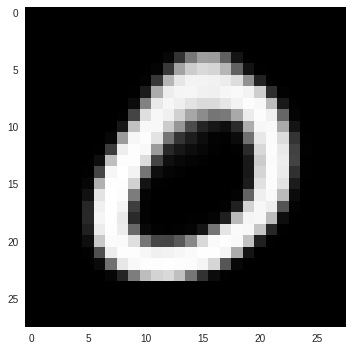

In [727]:
# plt.imshow(.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
latEx = GenerateMaen(MeansLatentSpace[0], StdsLatentSpace[0], 10)
latentspace_gen = np.random.normal(size=(100,20))
latentspace_gen[0] = latEx
g = vae.generate(latentspace_gen)
_ = PlotDistribution(g, 1, 1)

In [0]:
_latentspace_gen = np.random.normal(size=(100,20))

**Example generating digits from latent space randomly** 

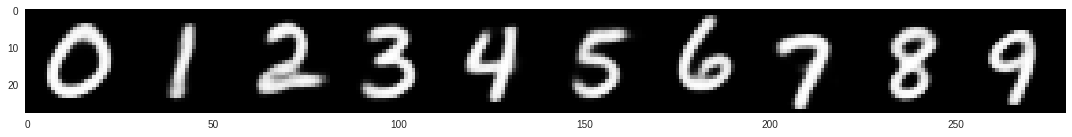

In [730]:
for inx in range(0, 10):
  latentspace_gen[inx] = GenerateMaen(MeansLatentSpace[inx], StdsLatentSpace[inx], 5)
generatedLatentSpace = vae.generate(latentspace_gen)
_ = PlotDistribution(generatedLatentSpace, nx = 10, ny = 1, size=(15, 15))

# Reformulate functions to generate digits of captcha

In [0]:
# Overview:
# Generate a sequence of images of the digits from the 'number'
# for example if 'number' = 1564, generate 4 images in that order [ Imagen(1), Imagen(5), Imagen(6), Imagen(4)]
# This function is the started point to generate the captcha
# Take randomly the latent space
def GenerateSequenceNumbersFromLatent(number, means, stds, model, factor = 1.4):
  # Get the digits
  digits = list()
  cocient = number
  while cocient > 0:
    res = cocient%10
    digits.append(res)
    cocient = int(cocient/10)
  digits.reverse()
  # Build the input tensor
  latentspace_v = np.random.normal(size=(100,20))
  for idx in range(0, len(digits)):
    latentspace_v[idx] = GenerateMaen(means[digits[idx]], stds[digits[idx]], factor)
    
  generatedFromLatentsMeans = model.generate(latentspace_v)
  
  #inputs = np.zeros((100, 784))
  #for indx in range(0, len(digits)):
  #  inputs[indx] = SelectRandomImage(container, digits[indx])
  #reconstructed = model.reconstruct(inputs)
  imgs_ans = list()
  for indx in range(0, len(digits)):
    imgs_ans.append(generatedFromLatentsMeans[indx])
  return imgs_ans

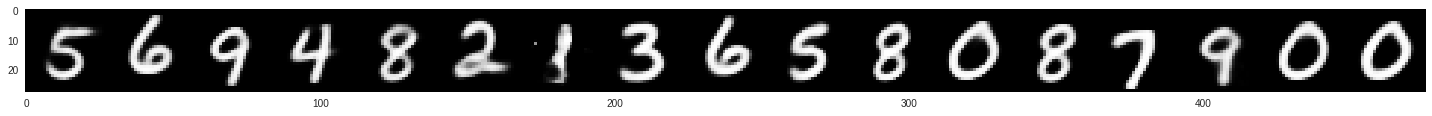

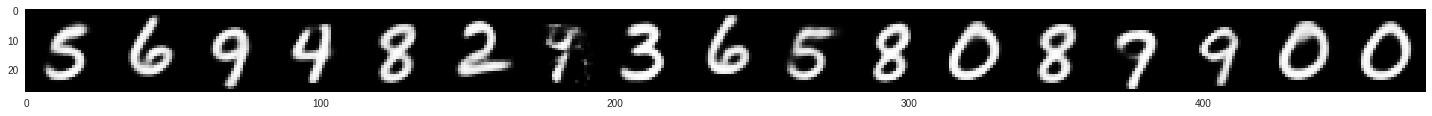

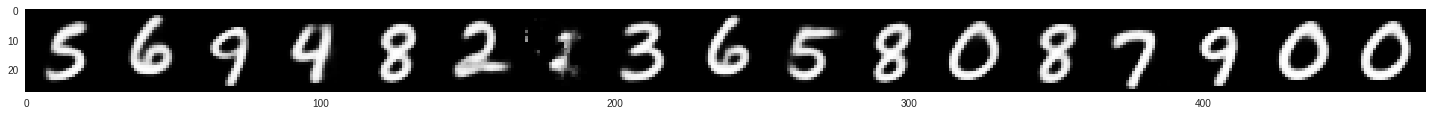

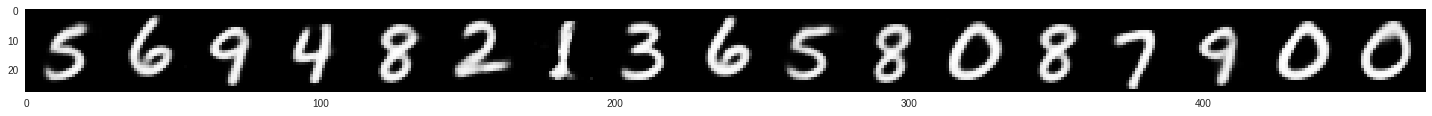

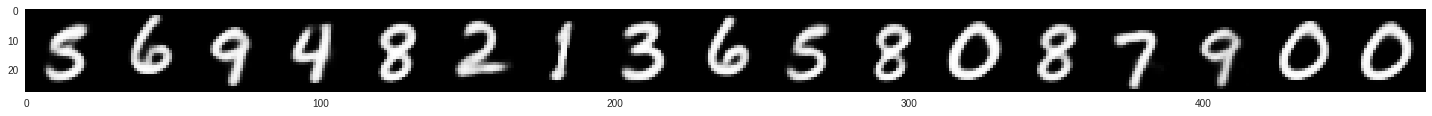

In [735]:
for _ in range(0, 5):
  imgsg = GenerateSequenceNumbersFromLatent(56948213658087900, MeansLatentSpace, StdsLatentSpace, vae, factor = 10)
  PlotDistribution(imgsg, nx = len(imgsg), ny = 1, size = (20, 20))

In [515]:
len(captcha1)

4

# TODO list
* add noise
* rotate digits
* translate digits
* scale digits
* add lines
* etc

# Noise

In [0]:
#add noise 
def noisy(noise_typ,image):
  if noise_typ == 1:  #gauss
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
  elif noise_typ == 2: #s&p
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
  elif noise_typ == 3: #poisson
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
  elif noise_typ == 4: #speckle
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy


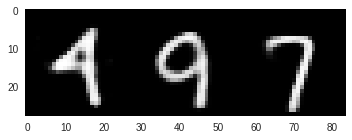

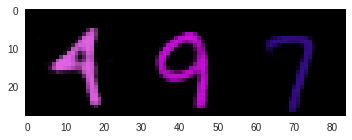

In [737]:
# 'generated' is a list of images generated by the VAE each element is a row of type np.narray of shape(784, )
generated = GenerateSequenceNumbers(497, im_input_elected, vae)
PlotDistribution(generated, nx = len(generated), ny = 1)
# Color the list 'generated'
ColoredIms = ColorListImagesRandomly(generated)
image = PlotDistributionRGB(ColoredIms, len(ColoredIms), 1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


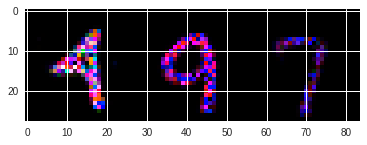

In [738]:
imageNoisy = noisy(4,image)
plt.imshow(imageNoisy, vmin=0, vmax=1)

# Rotation

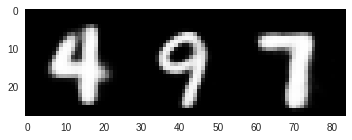

In [739]:
from PIL import Image
import imutils
# 'generated' is a list of images generated by the VAE each element is a row of type np.narray of shape(784, )
generated = GenerateSequenceNumbers(497, im_input_elected, vae)
image = PlotDistribution(generated, nx = len(generated), ny = 1)
#ColoredIms = ColorListImagesRandomly(generated)
#image = PlotDistributionRGB_2(ColoredIms, len(ColoredIms), 1)

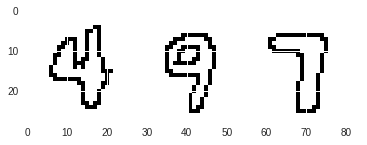

In [740]:
img = Image.fromarray(image*255)
#print(type(img))
open_cv_image = np.array(img)
arr = np.uint8(open_cv_image)
np.invert(arr)

#open_cv_image = np.array(img) 
#img = cv2.imread(img)
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#h,w = open_cv_image.shape
#mat = cv.CreateMat(h, w, cv.CV_32FC3)
#gra = cv.fromarray(mat)
gray = cv2.GaussianBlur(arr, (3, 3), 0)
#print(type(gray))
edged = cv2.Canny(gray, 2, 20)
plt.imshow(edged)

In [0]:
def rotate(image,angle):
  rotated = imutils.rotate(image,angle)
  return rotated

In [0]:
class settings:
  def __init__(self):
    import numpy as np
    self.color = np.random.randint(0, 2)
    self.angle = np.random.randint(-40, 40)
    #self.scale = np.random.rand(1)
    self.noisev = np.random.randint(0, 5)
    self.linex = np.random.randint(0,28)
    self.liney = np.random.randint(0,28)
    self.linexn = np.random.randint(0,28)
    self.lineyn = np.random.randint(0,28)

number= 5412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


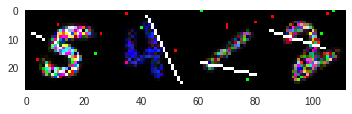

In [743]:
number = int(input('number= '))
captcha1 = GenerateSequenceNumbersFromLatent(number, MeansLatentSpace, StdsLatentSpace, vae)
listimage = []
for i in range(0, len(captcha1)):
  s = settings()
  if(s.color == 0):
    #img = Image.fromarray(captcha1[i]*255)
    #print(type(img))
    #open_cv_image = np.array(img)
    #arr = np.uint8(captcha1[i].reshape(28,28)*255.)
    #print("o")
    #plt.imshow(arr, vmin=0, vmax=255)
    #np.invert(arr)
    #image = np.array(captcha1[i])
    #gray = cv2.GaussianBlur(arr, (3, 3), 0)
    #imageResult = cv2.GaussianBlur(captcha1[i], (3, 3), 0)
    #print(type(gray))
    #print(arr.shape)
    imageResult = cv2.cvtColor(captcha1[i].reshape(28,28), cv2.COLOR_GRAY2BGR)
    #imageResult = arr
  else:
    ColoredIms = ColorListImagesRandomly([captcha1[i]])
    
    imageResult = ColoredIms[0]
  
  #plt.imshow(listimage[0], vmin=0, vmax=255)
  rotateImage = rotate(imageResult,s.angle)
  #print(rotateImage.shape)
  noisyImage = noisy(4,rotateImage)
  noisyImage = noisy(2,noisyImage)
  lineThickness = 1
  cv2.line(noisyImage, (s.linex,s.liney), (s.linexn, s.lineyn), (255,255,255), lineThickness)
  listimage.append(noisyImage)
_ = PlotDistributionRGB(listimage, nx = len(captcha1), ny = 1)

In [653]:
type(listimage[2])

numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


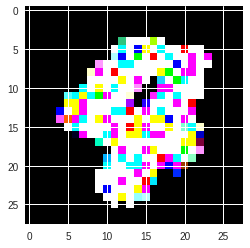

In [647]:
plt.imshow(listimage[1], vmin=0, vmax=255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


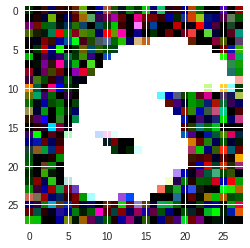

In [614]:
plt.imshow(noisy(1,listimage[0]), vmin=0, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


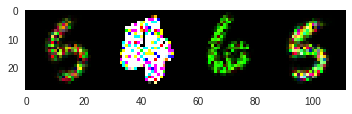

In [657]:
_ = PlotDistributionRGB(listimage, nx = len(captcha1), ny = 1)